In [11]:
# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dLuxToliman import ApplyBasisCLIMB, TolimanOpticalSystem

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'

from pathlib import Path

In [12]:
key = jr.PRNGKey(0)

wf_npix = 256 
diameter = 0.125 # This is default of toliman optical system. Can change.

### Can apply these to the input if you just want a clear aperture
m2_diameter = 0
strut_width = 0
###

wavelength = 585e-9

# This is to what degree we undersample Nyquist
nyquist_factor = 1
psf_npix = 256 / nyquist_factor
psf_pixel_scale = nyquist_factor * dlu.rad2arcsec(wavelength/(2*diameter))
oversample = nyquist_factor * 4 # sample at 4x nyquist originally

flux = 1e8
source = dl.PointSource(flux=flux,wavelengths=np.array([wavelength]))

# Optimisable binary mask
climb_basis = np.load("../xk4/files/basis.npy")
coefficients = 100*jr.normal(key, [len(climb_basis)])
mean_wl = source.wavelengths.mean()

# have to make sure that mean_wl is in meters.
mask_layer = ApplyBasisCLIMB(climb_basis, mean_wl, coefficients)

# Construct instrument
optics = TolimanOpticalSystem(wf_npixels=wf_npix,psf_npixels=psf_npix, mask=mask_layer, 
                            radial_orders=[2, 3], psf_pixel_scale=psf_pixel_scale, oversample=oversample)

# detector layer
detector_layers = [
    (
        'downsample',
        dl.detector_layers.Downsample(oversample)
    )
]

detector = dl.LayeredDetector(layers = detector_layers)

model = dl.Telescope(optics, source)

In [13]:
portion_flux_per_square_nyquist_element = 0.02
flux_per_pixel = portion_flux_per_square_nyquist_element*flux*(1/oversample**2)
print(flux_per_pixel)
# --- hyperparams you can tune ---
MAX_FLUX = flux_per_pixel        # photons/pixel (or whatever your units/normalisation are)
PENALTY_WEIGHT = 1e-3   # increase until the cap is respected
SMOOTH_TAU = 0.0       # set >0 for smooth hinge (e.g. 0.01 * MAX_FLUX)

def pixel_cap_penalty(img, cap=MAX_FLUX, weight=PENALTY_WEIGHT, tau=SMOOTH_TAU):
    """
    Penalize *every* pixel that exceeds `cap`.
    tau = 0.0  -> hard hinge (piecewise-smooth, subgrad at kink)
    tau > 0.0  -> smooth hinge using softplus with sharpness ~ 1/tau
    """
    if tau > 0.0:
        # smooth ReLU: tau * log(1 + exp((x - cap)/tau))
        excess = np.softplus((img - cap) / tau) * tau
    else:
        # hard hinge ReLU
        excess = np.clip(img - cap, a_min=0.0)
        # (effectively just adds the square error)
    # mean over all pixels keeps penalty magnitude roughly scale-invariant to image size
    return weight * np.mean(excess**2)


125000.0


In [14]:
# Marginal params
marginal_params = ['position','aperture.coefficients']

# Loss function
opt_param = 'pupil.coefficients'
@zdx.filter_jit
@zdx.filter_value_and_grad(opt_param)

def fim_loss_func(model, parameters):
    data = model.model()  # image, shape [H, W] (or [..., H, W] if batched)
    cov  = zdx.covariance_matrix(model, parameters, poiss_loglike, data=data)

    # FIM objective (trace of covariance -> minimize)
    trace = cov[0,0] + cov[1,1]
    fim_term = np.log10((trace))  # small epsilon for safety

    # Pixel cap penalty
    cap_term = pixel_cap_penalty(data, cap=MAX_FLUX, weight=PENALTY_WEIGHT, tau=SMOOTH_TAU)

    # Total loss
    return fim_term + cap_term

In [15]:
# working
optim, opt_state = zdx.get_optimiser(model, opt_param, optax.adam(2e1))

losses, models_out = [], [model]
with tqdm(range(400), desc='Gradient Descent') as t:
    for i in t:
        loss, grads = fim_loss_func(model, marginal_params)
        updates, opt_state = optim.update(grads, opt_state)   # your zdx API
        model = zdx.apply_updates(model, updates)
        models_out.append(model)
        losses.append(loss)
        t.set_description("Loss: {:.6f}".format(float(loss)))


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

In [18]:
from copy import deepcopy

def strip_layer(optics, layer_name="pupil"):
    # Get items in a uniform way
    if isinstance(optics.layers, dict):
        items = list(optics.layers.items())
    else:
        items = list(optics.layers)  # already list of (name, layer)

    # Build the new layers as a list of (name, layer) tuples
    new_layers = []
    for name, layer in items:
        if name == layer_name:
            continue
        # must be (str, OpticalLayer) — not strings, not names only
        new_layers.append((name, deepcopy(layer)))

    # Construct a plain AngularOpticalSystem with the pupil removed
    return dl.AngularOpticalSystem(
        wf_npixels      = optics.wf_npixels,
        diameter        = optics.diameter,
        layers          = new_layers,              # <-- list of (name, OpticalLayer)
        psf_npixels     = optics.psf_npixels,
        oversample      = optics.oversample,
        psf_pixel_scale = optics.psf_pixel_scale,
    )

central_optics = strip_layer(model.optics, "pupil")
model_ng = dl.Telescope(
    optics = central_optics,
    source = source
)

# Marginal params
#marginal_params = ['position', 'flux','aperture.coefficients']

data_ng = model_ng.model()
cov_ng = zdx.covariance_matrix(model_ng, marginal_params, poiss_loglike, data=data_ng)

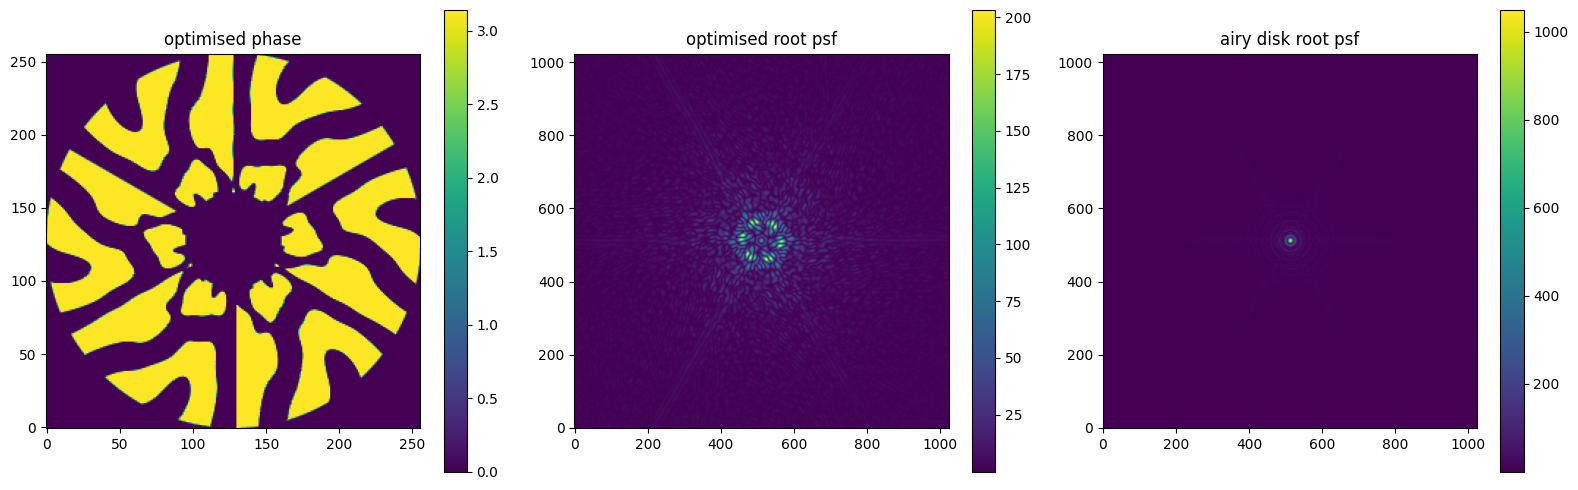

In [19]:
final_model = models_out[-1]
final_data = final_model.model()

plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.title('optimised phase')
plt.imshow(final_model.get_binary_phase()*final_model.aperture.transmission)
plt.colorbar()

plt.subplot(1,3,2)
plt.title('optimised root psf')
plt.imshow(final_data**0.5)
plt.colorbar()

plt.subplot(1,3,3)
plt.title('airy disk root psf')
plt.imshow(data_ng**0.5)
plt.colorbar()

plt.tight_layout()
plt.show()
#print(np.sum(central_psf_f)+np.sum(sidelobe_psf_f))

In [20]:
cov = zdx.covariance_matrix(final_model, marginal_params, poiss_loglike, data=final_data)

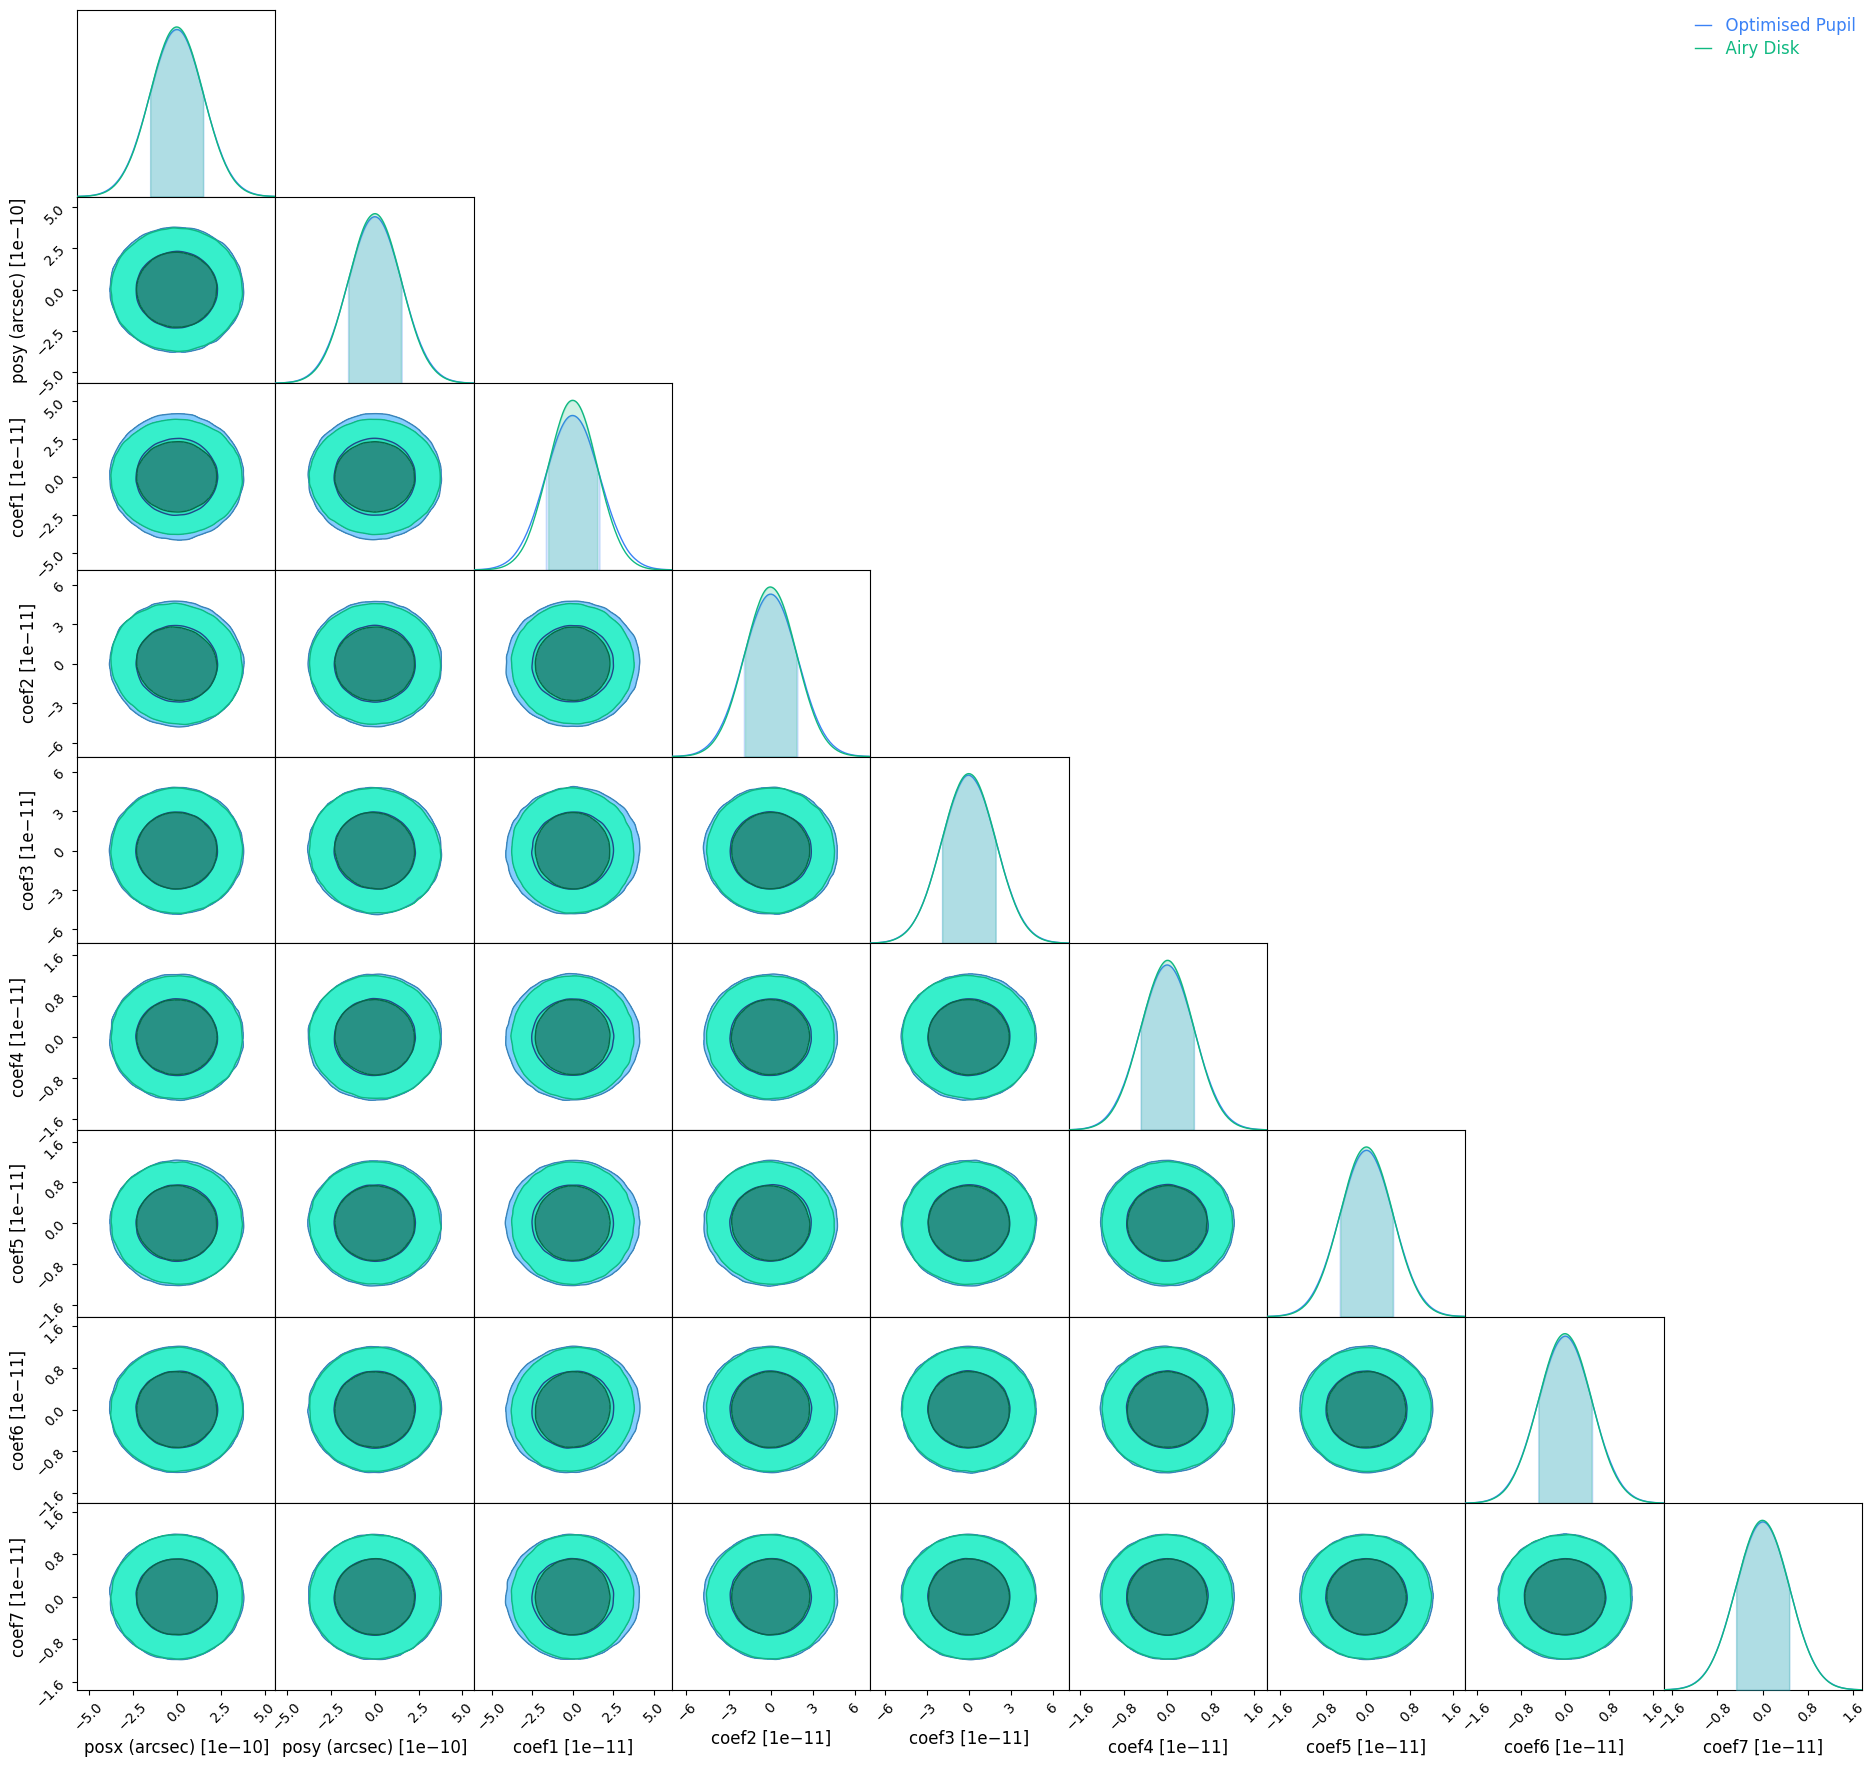

In [31]:
from chainconsumer import ChainConsumer, Chain
param_names = ["posx (arcsec)","posy (arcsec)","coef1","coef2","coef3","coef4","coef5","coef6","coef7"]
X = np.zeros(len(param_names))

c = ChainConsumer()
# This 'commented out' one is just before optimisation
# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=dlu.rad2arcsec(covs[0]), columns=param_names, name="Initial")
# )

# To convert to arcsec, have to square the conversion factor
cov_to_arcsec = 1 #dlu.rad2arcsec(1)**2

c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov*cov_to_arcsec, columns=param_names, name="Optimised Pupil")
)
c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov_ng*cov_to_arcsec, columns=param_names, name='Airy Disk')
)

#c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
fig = c.plotter.plot()
# this is an incredibly good result.

In [26]:
import numpyro as npy
import numpyro.distributions as dist

parameters = ['position']#,'aperture.coefficients']

def psf_model(data, model):
    """
    NumPyro probabilistic model:
    - 'position': 2D vector (Uniform[-1, 1])
    - 'aperture.coefficients': 7D vector (Uniform[-1, 1])
    """
    values = [
        npy.sample("position", dist.Uniform(dlu.arcsec2rad(-1e-4), dlu.arcsec2rad(1e-4)).expand([2])),
        #npy.sample("aperture.coefficients", dist.Uniform(-1e-9, 1e-9).expand([7]))
    ]
    
    predicted = model.set(parameters, values).model().flatten()

    with npy.plate("data", len(data.flatten())):
        npy.sample("psf", dist.Poisson(predicted), obs=data.flatten())

In [27]:
data = final_data
from jax import device_count
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),    
    num_warmup=2000,
    num_samples=2000,
    num_chains=device_count(),
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data, final_model)

sample: 100%|██████████| 4000/4000 [34:38<00:00,  1.92it/s, 7 steps of size 7.59e-01. acc. prob=0.91]  

CPU times: user 2h 49min 7s, sys: 2min 1s, total: 2h 51min 8s
Wall time: 34min 39s


In [28]:
sampler.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
position[0]     -0.00      0.00     -0.00     -0.00      0.00   1783.37      1.00
position[1]     -0.00      0.00      0.00     -0.00      0.00   1407.93      1.00

Number of divergences: 0


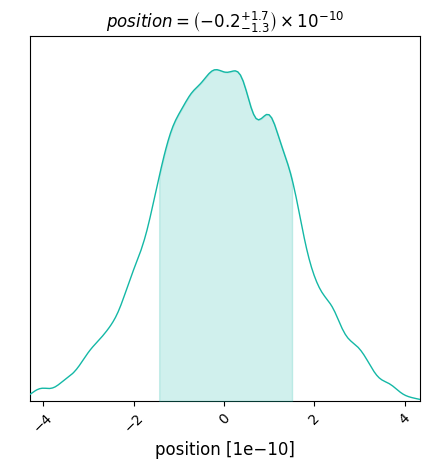

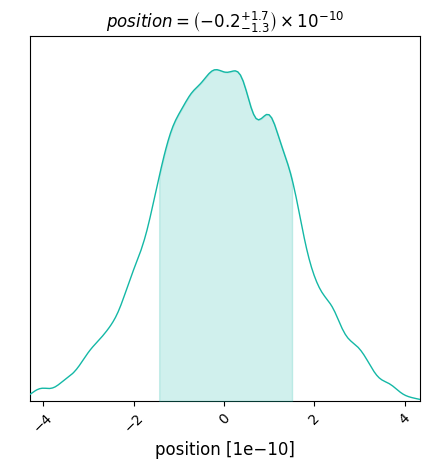

In [30]:
chain = Chain.from_numpyro(sampler, "Parameter Inference", color="teal", shade_alpha=0.2)
consumer = ChainConsumer().add_chain(chain)
consumer.plotter.plot()